<a href="https://colab.research.google.com/github/Jorgvt/LibroDL/blob/main/Capitulo_6/RL%20CARTPOLE/CARTPOLE_DOUBLE_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APRENDIZAJE REFORZADO: CARTPOLE de gym con DQN 

## 1. Cargamos librerías

In [1]:
import random
from collections import deque
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import Adam

import gym

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'gray'

## 2. Diseñamos el modelo DQN

### 2.1 Creamos una clase llamada DQN

In [3]:
class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # ratio de descuento
        self.epsilon = 1.0  # ratio de exploración
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        states = tf.keras.Input(shape = (self.state_size,))
        x = layers.Dense(64, activation= 'sigmoid')(states)
        y = layers.Dense(32, activation= 'sigmoid')(x)
        q_values = layers.Dense(self.action_size, activation= 'linear')(y)
        model = tf.keras.Model(inputs = states, outputs = q_values)
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def action(self, state):
        if np.random.rand() <= self.epsilon:
          return random.randrange(self.action_size)
        else:
          act_values = self.model.predict(state)
          return np.argmax(act_values[0])

    def sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def experience_replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            update_input[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            update_target[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        target = self.model.predict(update_input)
        target_next = self.model.predict(update_target)
        target_val = self.target_model.predict(update_target)

        for i in range(batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                a = np.argmax(target_next[i])
                target[i][action[i]] = reward[i]+self.gamma*(target_val[i][a])
        self.model.fit(update_input, target, 
                       batch_size=batch_size,
                       epochs=1, 
                       verbose=0)



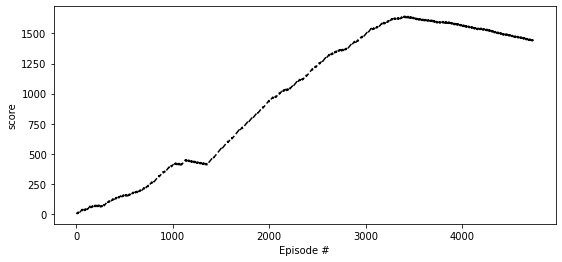

episode: 299/300, score: 1437.0, e: 0.01


In [4]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)
done = False
score = 0
batch_size = 32
EPISODES=300
rewards = []
scores = []
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(100):
        action = agent.action(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        rewards.append(reward)
        score += reward
        scores.append(score)
        next_state = np.reshape(next_state, [1, state_size])
        agent.sample(state, action, reward, next_state, done)
        state = next_state
        if done:
           agent.update_target_model()
           clear_output(True)
           fig = plt.figure()
           ax = fig.add_subplot(111)
           plt.plot(np.arange(len(scores)), scores, 'k--')
           plt.ylabel('score')
           plt.xlabel('Episode #')
           plt.savefig("cartpole_ddqn.png")
           plt.show()
           print("episode: {}/{}, score: {}, e: {:.2}"
                 .format(e, EPISODES, score, agent.epsilon))
           break
        if len(agent.memory) > batch_size:
            agent.experience_replay(batch_size)
        if e % 10 == 0:
            agent.model.save_weights("cartpole_ddqn.h5")